# Robustness
Experimenting with changes to:
- bins
- before/after period

In [1]:
import preprocessing
from config import TRENDS_DIR
%load_ext autoreload
%autoreload 2
import pandas as pd
import tqdm
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
from config import TWITTER_DATA_DIR
import pickle
import seaborn as sns
import statsmodels.formula.api as smf
import graphviz as gr
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
def get_trend_behavior(ht):
    '''Takes a hashtag and compiles all trend date about it
    Currently just returns the beginning and end of the trending status, but can do more potentially
    '''
    res = [] 
    for entry in os.scandir(TRENDS_DIR):
        # crude filtering for date csv names 
        if entry.path[-7] == '-':
            df = pd.read_csv(entry, header=None,
                            names=['hashtag', 'place', 
                                   'level', 'day', 
                                   'time', 'volume', 'nan'])
            df['hashtag'] = df.hashtag.apply(lambda x: x.replace('#','').lower())
            try:
                df['datetime'] = pd.to_datetime(df.day + df.time, format='%Y-%m-%d%H:%M')
            except:
                print('error with hashtag', ht)
                return df
            temp = df.query(f'hashtag == "{ht}"')
            if len(temp) > 0:
                res.append(temp)
    if len(res) > 0:
        return pd.concat(res)
    else:
        print(ht, 'did not appear to trend')
        return pd.DataFrame()

In [3]:
campaigns = preprocessing.load_campaign()

In [4]:
hashtag = 'jharkhandwithmodi'
tweets = campaigns[hashtag]

In [5]:
with open(os.path.join(TWITTER_DATA_DIR, 'exposure_results.pkl'), 'rb') as f:
    exposures = pickle.load(f)

In [6]:
def plot_trending_ts(df, exact_trending_loc, cols=['zero_exposure_regular', 'total_engagement']):
    # takes a df and plots the time series with some acoutrements
    fig = plt.figure(figsize=(14,9))

    trending_data = pd.read_csv(os.path.join(TRENDS_DIR, hashtag+'.csv'), parse_dates=['datetime'])
  
    start = trending_data.datetime.min() + timedelta(hours=5, minutes=30)
    end = trending_data.datetime.max() + timedelta(hours=5, minutes=30)

    min_date = start - timedelta(hours=6)
    max_date = end + timedelta(hours=6)
    for i, col in enumerate(cols):
        ax = plt.subplot(2, 1, i+1)
        temp = df[col]
        ax.scatter(temp.index, temp, label='Zero Exposure Tweets')

        ax.axvline(exact_trending_loc, color='r', ls='--', label='Inferred Trending Time')
        _, max_hist_level = ax.get_ylim()
        ax.plot([start - timedelta(hours=1), start], [max_hist_level*1.1]*2, '|--', color='black', alpha=1, 
                 label='Resolution Error') 
        ax.plot([start, end], [max_hist_level]*2, '-', color='black', alpha=1) 
        ax.plot([start, end], [max_hist_level]*2, '|', color='black') 
        ax.text(start + (end-start)/2, max_hist_level/1.1, f'#{hashtag} trending', fontsize=12, horizontalalignment='center')
        ax.set_xlabel('Time', fontsize=18)
        ax.set_ylabel('Tweet volume', fontsize=16)
        ax.set_xlim(min_date, max_date)
        ax.set_title(col)
        import matplotlib.dates as mdates
        hours = mdates.HourLocator() 
        minutes  = mdates.MinuteLocator(byminute=range(0,61,15))
        ax.xaxis.set_major_locator(hours)
        ax.xaxis.set_minor_locator(minutes)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        #ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
        ax.grid(True)
        ax.grid(True, 'minor')
        
        
    fig.autofmt_xdate()
#     handles, labels = plt.gca().get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys())
#     plt.legend()
    fig.suptitle(f'#{hashtag} Tweets Over Time')
#     plt.tight_layout()    
#     plt.show()

In [7]:
def build_df(hashtag, tweet_dict, time_bin='5Min', plot=False,
            normalize_time=False):
    # returns timeseries and inferred trending time
    for t_id, tweet in tweet_dict.items():
        tweet['adj_date'] = tweet['date'] + timedelta(hours=5, minutes=30)
        if tweet['retweet_from'] == '':
            if tweet['template'] != '':
                tweet['type'] = 'template'
            else:
                tweet['type'] = 'regular'
        else:
            if tweet['template'] != '':
                tweet['type'] = 'template_retweet'
            else:
                tweet['type'] = 'regular_retweet'
    
        t_exp, n_exp, _ = exposures[hashtag][tweet['username']]
        tweet['template_exposure'] = t_exp
        tweet['normal_exposure'] = n_exp
        tweet['total_exposure'] = t_exp + n_exp
                
    df = pd.DataFrame.from_dict(tweet_dict).transpose()
    df.index = df['adj_date']
        
    trending_data = pd.read_csv(os.path.join(TRENDS_DIR, hashtag+'.csv'), parse_dates=['datetime'])
  
    start = trending_data.datetime.min() + timedelta(hours=5, minutes=30)
    end = trending_data.datetime.max() + timedelta(hours=5, minutes=30)

    min_date = start - timedelta(hours=6)
    max_date = end + timedelta(hours=6)

    colors = ["red","orange",'black','grey']
    types = ['template', 'template_retweet', 'regular', 'regular_retweet']

    series_list = []
    for t in types:
        temp = df[df.type == t] # only use regular tweets
        temp = temp.resample(time_bin).count().username.loc[min_date:max_date]
        series_list.append(temp)
    temp = df[df.type == 'regular'] # only use regular tweets
    series_list.append(temp[temp.total_exposure > 0].resample(time_bin).count().username.loc[min_date:max_date])
    temp = temp[temp.total_exposure == 0].resample(time_bin).count().username.loc[min_date:max_date]
    series_list.append(temp)
    
    new_df = pd.DataFrame(series_list).T
    new_df.columns=[*types, 'zero_exposure_regular', 'nonzero_exposure_regular']
    new_df['total_engagement'] = new_df[types].sum(axis=1)
    new_df['rt_engagement'] = new_df[['regular_retweet', 'template_retweet']].sum(axis=1)
    
    def find_jump(x, start):
        # takes a ts and finds the spike within the start period
        return start # just return what the thing says
        diffed = x.diff()
        delta = pd.Timedelta(diffed.index.values[1] - diffed.index.values[0])
        for i in range(10):
            candidate = diffed.idxmax()
            if candidate >= start-timedelta(hours=1, minutes=5) and candidate < start:
                return candidate - delta
            else: # zero out the candidate
                diffed[candidate] = 0
        # no spike found in trending range
        return start #- timedelta(hours=1, minutes=5)
    
    exact_trending_loc = find_jump(temp, start)
    
    if normalize_time:
        new_df.index = new_df.index - exact_trending_loc
        new_df.index = new_df.index.map(lambda x: int(x.total_seconds() / 60))
        exact_trending_loc = 0

    new_df['time'] = new_df.index
    new_df['time_i'] = range(len(new_df))
    new_df['time_i2'] = new_df['time_i']*new_df['time_i']
    new_df['trending_start'] = start
    new_df['inferred_trending_start'] = exact_trending_loc
    
    if plot:
        plot_trending_ts(new_df, exact_trending_loc)
    return new_df, exact_trending_loc

In [8]:
def run_statistics_2(data, thresh, periods=(12,12),
                   model_fit_args=dict(cov_type='HAC',cov_kwds={'maxlags':1})):
    
    def simple_table_to_df(tab, prefix):
        df = pd.read_html(tab.as_html(), index_col=0, header=0)[0]
        return pd.concat({prefix: df}, names=['Trial'])
    
    rdd_df = data.assign(threshold=(data.time > thresh).astype(int))
    try:
        i_thresh = data.time_i[data.time == thresh].values[0]
    except:
        return rdd_df
    # data effects around trending status
    rdd_df = rdd_df.iloc[i_thresh-periods[0]:i_thresh+periods[1]]
    
    model = smf.wls("regular~time_i*threshold+nonzero_exposure_regular", rdd_df).fit(**model_fit_args)
    res_df = simple_table_to_df(model.summary().tables[1], 'New Tweets')
    def highlight_significant(s):
        res = 'background-color: yellow' if s.z >= 1.96 else ''
        return [res for x in s] 

    display(res_df.style.apply(highlight_significant, axis=1))
    return res_df

coef  std err      z  P>|z|  [0.025  \
Trial                                                                         
New Tweets Intercept                  5.5519    3.707  1.498  0.134  -1.714   
           time_i                    -0.0128    0.011 -1.160  0.246  -0.034   
           threshold                -11.0894    5.527 -2.007  0.045 -21.921   
           time_i:threshold           0.0316    0.015  2.056  0.040   0.001   
           nonzero_exposure_regular   1.3393    0.309  4.330  0.000   0.733   

                                     0.975]  
Trial                                        
New Tweets Intercept                 12.818  
           time_i                     0.009  
           threshold                 -0.257  
           time_i:threshold           0.062  
           nonzero_exposure_regular   1.945

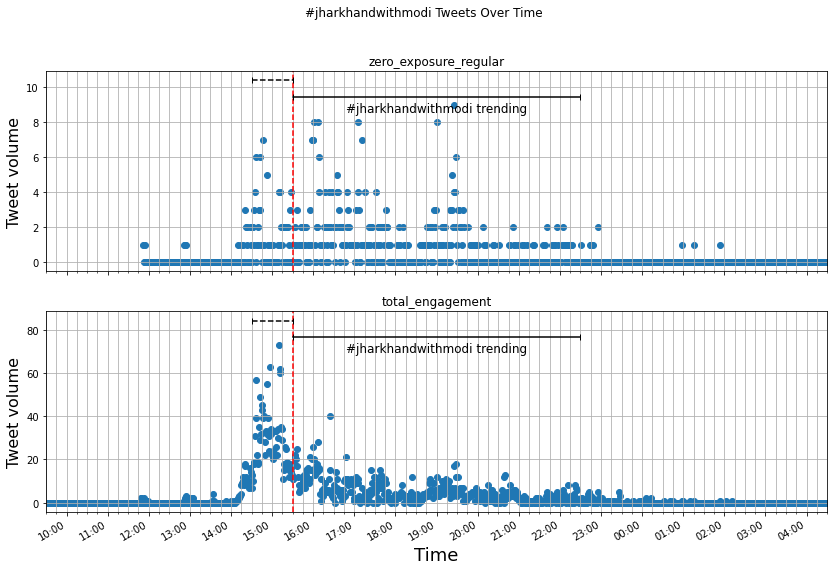

In [9]:
res = run_statistics_2(*build_df(hashtag, tweets, time_bin='1Min', plot=True), periods=(60,60))
res

In [10]:
meta_res = []
for hashtag, tweet_dict in campaigns.items():
    try:
        res = run_statistics_2(*build_df(hashtag, tweet_dict, time_bin='1Min'), periods=(60,60))
        meta_res.append(pd.concat({hashtag: res}, names=['Hashtag']))
    except: 
        print(hashtag, ' did not work')

timesofrahul  did not work


congressinsultsairforce  did not work


bogibeelbridge  did not work


congressdefencescams  did not work
hooghly_chalo  did not work


goodgovernanceday  did not work


namowithtraders  did not work


indiabolemodidobara  did not work


zamanatke1000din  did not work


congressframedamitshah  did not work
mainbhichowkidar  did not work


congressagainstnationalsecurity  did not work
आदर्शघोटाला_संघर्ष_यात्रा  did not work


bjpvijaysankalpbikerally  did not work


congresseurofighterscandal  did not work


bjpkamaljyoti  did not work


modiagain2019  did not work


armedforcesflagday  did not work
nris4modi  did not work
modifiedtextiles  did not work


modifiedjobs  did not work


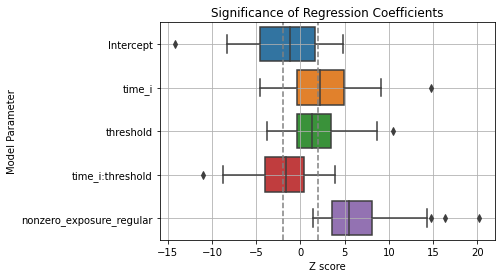

In [11]:
df = pd.concat(meta_res)
df['Trial'] = df.index.get_level_values(1)
df['Variable'] = df.index.get_level_values(2)
df['Hashtag'] = df.index.get_level_values(0)

sns.boxplot(x='z', y='Variable', data=df)
plt.grid(True)
plt.title('Significance of Regression Coefficients')
plt.xlabel('Z score')
plt.ylabel('Model Parameter')
plt.axvline(2, color='grey', ls='--')
plt.axvline(-2, color='grey', ls='--')

Text(0, 0.5, 'Model Parameter')

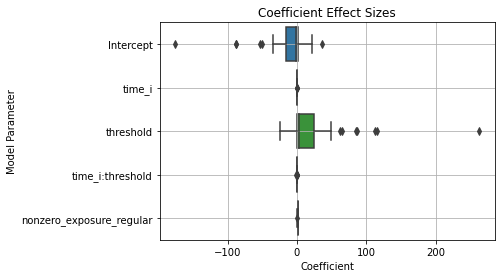

In [12]:
df = pd.concat(meta_res)
df['Trial'] = df.index.get_level_values(1)
df['Variable'] = df.index.get_level_values(2)
df['Hashtag'] = df.index.get_level_values(0)

sns.boxplot(x='coef', y='Variable', data=df)
plt.grid(True)
plt.title('Coefficient Effect Sizes')
plt.xlabel('Coefficient')
plt.ylabel('Model Parameter')

In [66]:
import seaborn as sns

In [113]:
def meta_analysis(df):
    idx = pd.IndexSlice
    df['Trial'] = df.index.get_level_values(1)
    df['Variable'] = df.index.get_level_values(2)
    df['Hashtag'] = df.index.get_level_values(0)
    
    temp = df.loc[idx[:, :, ['threshold']], :] # ['threshold']], :]
    sns.boxplot(x='coef', y='Trial', data=temp)
    plt.grid(True)
    plt.title('Trending Topics Effect Size')
    plt.xlabel('Coefficient')
    plt.ylabel('Model')

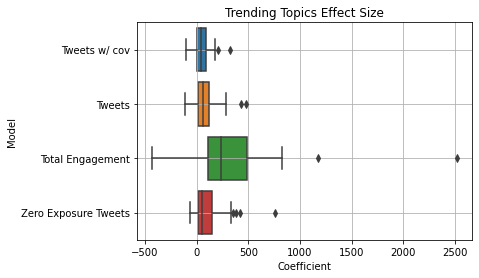

In [114]:
meta_analysis(pd.concat(meta_res))

## TODO
- analyze entire panel
- add logs
- sensitivity to bin size
- 

## Combining All Hashtags and Normalizing Time

$Y_{iht} = \gamma_{h} + \lambda_t + \beta D_{ht} + \epsilon_{iht}$

In [13]:
dfs = []
for hashtag, tweet_dict in campaigns.items():
    try:
        temp, _ = build_df(hashtag, tweet_dict, normalize_time=True, time_bin='1Min')
        temp = temp.assign(threshold=(temp.time > 0).astype(int))
        temp['hashtag'] = hashtag
        dfs.append(temp)
    except Exception as e:
        print(e, hashtag, 'did not work')
        
panel_df = pd.concat(dfs)
panel_df

'bogibeelbridge' bogibeelbridge did not work
'datetime' is not in list hooghly_chalo did not work
'goodgovernanceday' goodgovernanceday did not work
'datetime' is not in list congressframedamitshah did not work
'mainbhichowkidar' mainbhichowkidar did not work
'datetime' is not in list congressagainstnationalsecurity did not work
'bjpvijaysankalpbikerally' bjpvijaysankalpbikerally did not work
'bjpkamaljyoti' bjpkamaljyoti did not work
'modiagain2019' modiagain2019 did not work
'armedforcesflagday' armedforcesflagday did not work
'datetime' is not in list nris4modi did not work


,template,template_retweet,regular,regular_retweet,zero_exposure_regular,nonzero_exposure_regular,total_engagement,rt_engagement,time,time_i,time_i2,trending_start,inferred_trending_start,threshold,hashtag
adj_date,,,,,,,,,,,,,,,
-360,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-360,0,0,2019-02-17 15:30:00,0,0,jharkhandwithmodi
-359,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-359,1,1,2019-02-17 15:30:00,0,0,jharkhandwithmodi
-358,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-358,2,4,2019-02-17 15:30:00,0,0,jharkhandwithmodi
-357,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-357,3,9,2019-02-17 15:30:00,0,0,jharkhandwithmodi
-356,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-356,4,16,2019-02-17 15:30:00,0,0,jharkhandwithmodi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,896,1256,1577536,2018-10-11 23:30:00,0,1,gappupappu
897,NaN,0.0,0.0,1.0,0.0,0.0,1.0,1.0,897,1257,1580049,2018-10-11 23:30:00,0,1,gappupappu
898,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,898,1258,1582564,2018-10-11 23:30:00,0,1,gappupappu


In [14]:
query = panel_df.query('time > -60 & time < 60').fillna(0)
# convert hashtags to numeric
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()
mod = smf.ols("regular ~ time*threshold + C(hashtag) + nonzero_exposure_regular", data=query).fit(cov_type='cluster', cov_kwds={'groups': query['hashtag']} )
temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df.loc[~temp_df.index.str.startswith('C', na=False)]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,1.4766,0.310,4.761,0.000,0.869,2.084
time,0.0468,0.012,3.772,0.000,0.022,0.071
threshold,-0.4981,0.337,-1.479,0.139,-1.158,0.162
time:threshold,-0.0604,0.015,-4.000,0.000,-0.090,-0.031
nonzero_exposure_regular,1.5230,0.149,10.194,0.000,1.230,1.816


In [246]:
panel_df

,template,template_retweet,regular,regular_retweet,zero_exposure_regular,nonzero_exposure_regular,total_engagement,rt_engagement,time,time_i,time_i2,threshold,hashtag
adj_date,,,,,,,,,,,,,
-295,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-295,0,0,0,jharkhandwithmodi
-290,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-290,1,1,0,jharkhandwithmodi
-285,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-285,2,4,0,jharkhandwithmodi
-280,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-280,3,9,0,jharkhandwithmodi
-275,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-275,4,16,0,jharkhandwithmodi
...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,NaN,0.0,1.0,6.0,1.0,0.0,7.0,6.0,945,248,61504,1,gappupappu
950,NaN,0.0,4.0,3.0,3.0,1.0,7.0,3.0,950,249,62001,1,gappupappu
955,NaN,0.0,1.0,2.0,1.0,0.0,3.0,2.0,955,250,62500,1,gappupappu


In [ ]:
query = panel_df.query('time > -60 & time < 60').fillna(0)
# convert hashtags to numeric
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()
mod = smf.ols("regular ~ time*threshold + C(hashtag) + nonzero_exposure_regular", data=query).fit(cov_type='cluster', cov_kwds={'groups': query['hashtag']} )
mod.summary()

In [218]:
query = panel_df.query('time > -60 & time < 60').fillna(0)
# convert hashtags to numeric
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()
mod = smf.ols("regular ~ time*threshold + C(hashtag) + nonzero_exposure_regular", data=query).fit(
    cov_type='HAC',cov_kwds={'maxlags':1})
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                regular   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     22.27
Date:                Mon, 11 Jan 2021   Prob (F-statistic):          7.88e-169
Time:                        15:15:55   Log-Likelihood:                -5188.5
No. Observations:                1347   AIC:                         1.051e+04
Df Residuals:                    1279   BIC:                         1.087e+04
Df Model:                          67                                         
Covariance Type:                  HAC                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.4053      1.445      0.280      0.779      -2.427       3.238
C(hashtag)[T.1]             11.3350      2.582      4.391      0.000       6.275      16.395
C(hashtag)[T.2]              2.0640      1.346      1.533      0.125      -0.575       4.703
C(hashtag)[T.3]              1.5154      1.639      0.924      0.355      -1.698       4.729
C(hashtag)[T.4]             28.6981      4.504      6.371      0.000      19.870      37.526
C(hashtag)[T.5]              7.2965      1.819      4.011      0.000       3.731      10.862
C(hashtag)[T.6]              0.0948      1.481      0.064      0.949      -2.808       2.998
C(hashtag)[T.7]              1.9834      1.603      1.237      0.216      -1.159       5.126
C(hashtag)[T.8]              5.6624      1.629      3.476      0.001       2.469       8.855
C(hashtag)[T.9]             -1.1223      1.831     -0.613      0.540      -4.711       2.466
C(hashtag)[T.10]            -0.6327      1.822     -0.347      0.728      -4.204       2.938
C(hashtag)[T.11]            -3.4677      1.281     -2.706      0.007      -5.979      -0.956
C(hashtag)[T.12]            -1.1939      1.464     -0.816      0.415      -4.063       1.675
C(hashtag)[T.13]             6.9267      1.968      3.520      0.000       3.069      10.784
C(hashtag)[T.14]            -3.1721      4.231     -0.750      0.453     -11.464       5.120
C(hashtag)[T.15]             0.1178      1.569      0.075      0.940      -2.957       3.192
C(hashtag)[T.16]             4.4699      2.073      2.156      0.031       0.406       8.534
C(hashtag)[T.17]             3.4553      1.681      2.055      0.040       0.160       6.750
C(hashtag)[T.18]             7.4026      1.620      4.570      0.000       4.228      10.577
C(hashtag)[T.19]             0.1612      1.705      0.095      0.925      -3.181       3.504
C(hashtag)[T.20]            19.2375      6.740      2.854      0.004       6.028      32.447
C(hashtag)[T.21]             4.3747      2.096      2.088      0.037       0.268       8.482
C(hashtag)[T.22]            17.3390      3.314      5.231      0.000      10.843      23.835
C(hashtag)[T.23]             1.4382      1.670      0.861      0.389      -1.835       4.711
C(hashtag)[T.24]             2.4255      1.481      1.638      0.101      -0.477       5.328
C(hashtag)[T.25]             5.6599      2.767      2.046      0.041       0.237      11.083
C(hashtag)[T.26]            13.7801      3.660      3.765      0.000       6.606      20.954
C(hashtag)[T.27]             0.5726      1.353      0.423      0.672      -2.079       3.224
C(hashtag)[T.28]            22.0277      4.550      4.841      0.000      13.110      30.946
C(hashtag)[T.29]            -0.0420      1.485     -0.028      0.977      -2.952       2.869
C(hashtag)[T.3

In [117]:
len(exposures.keys())

68

In [131]:
x.columns

Index(['template', 'template_retweet', 'regular', 'regular_retweet',
       'zero_exposure_regular', 'nonzero_exposure_regular', 'time', 'time_i',
       'time_i2', 'total_engagement', 'rt_engagement'],
      dtype='object')

In [163]:
def plot_all_event_study(quantiles=(.1,.99), time_bin='5Min'):
    # plot everything
    fig, axs = plt.subplots(2, 1, figsize=(14,9))
    for hashtag, tweet_dict in campaigns.items():
        try:
            temp, _ = build_df(hashtag, tweet_dict, normalize_time=True)
            axs[0].plot(temp.index, temp.zero_exposure_regular,
                    alpha=.4)
            axs[1].plot(temp.index, temp.total_engagement, alpha=.4)

        except Exception as e:
            print(hashtag, 'did not work')
            print(e)

    axs[1].set_xlabel('Minutes Since Trending', fontsize=18)
    axs[0].set_ylabel('Tweet volume', fontsize=16)
    axs[1].set_ylabel('Tweet volume', fontsize=16)
    axs[0].set_xlim(-100, 200)
    axs[1].set_xlim(-100, 200)
    axs[0].set_title('Zero Exposure Tweets')
    axs[1].set_title('Total Engagement')
    axs[0].grid()
    axs[1].grid()

bogibeelbridge did not work
'bogibeelbridge'
hooghly_chalo did not work
'datetime' is not in list
goodgovernanceday did not work
'goodgovernanceday'
congressframedamitshah did not work
'datetime' is not in list
mainbhichowkidar did not work
'mainbhichowkidar'
congressagainstnationalsecurity did not work
'datetime' is not in list
bjpvijaysankalpbikerally did not work
'bjpvijaysankalpbikerally'
bjpkamaljyoti did not work
'bjpkamaljyoti'
modiagain2019 did not work
'modiagain2019'
armedforcesflagday did not work
'armedforcesflagday'
nris4modi did not work
'datetime' is not in list


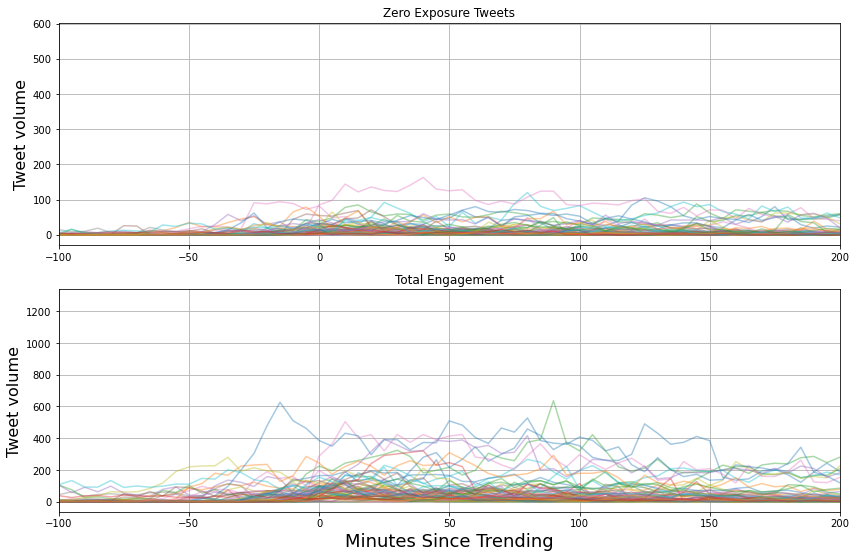

In [164]:
plot_all_event_study()

In [34]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge jinja2

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/jschless/.conda/envs/gt:

The following NEW packages will be INSTALLED:

    jinja2:     2.11.2-pyh9f0ad1d_0  conda-forge
    markupsafe: 1.1.1-py38h497a2fe_3 conda-forge

markupsafe-1.1 100% |################################| Time: 0:00:00 139.12 kB/s
jinja2-2.11.2- 100% |################################| Time: 0:00:00  19.24 MB/s
